# Backtest Trading Simulator
### Imports

In [2]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Python-Trader-Backtest.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/Python-Trader-Backtest/src")

Cloning into 'Python-Trader-Backtest'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 497 (delta 95), reused 120 (delta 50), pack-reused 320
Receiving objects: 100% (497/497), 3.01 MiB | 25.50 MiB/s, done.
Resolving deltas: 100% (279/279), done.


In [4]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 15.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
import sys
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
# sys.path.insert(1, '../src')

from markets import Market
from brokers import Broker
from traders import Trader
from utils import market_plot, profit_and_portfolio_value, profits, portfolio_values, liquids, fees_and_tax, yields



### Simulator function

In [6]:
def simulator(liquid, tickers, periods, ratios, sell_strategy, start_date, end_date, buy_fee,
              min_buy_fee, sell_fee, min_sell_fee, tax, verbose, plots_normalize):

    traders_list = []
    market = Market(tickers, start_date=start_date, end_date=end_date)
    broker = Broker(buy_fee=buy_fee, min_buy_fee=min_buy_fee, sell_fee=sell_fee,
                    min_sell_fee=min_sell_fee, tax=tax, my_market=market)
    first_date = cp.copy(market.current_date)

    for i, period in enumerate(periods):
        print(f'period: {period}')

        # init market
        market.current_idx = 0
        market.current_date = first_date

        # init new trader
        trader = Trader(liquid=liquid, balance_period=period, broker=broker, market=market,
                        verbose=verbose, sell_strategy=sell_strategy)

        # buy some stocks
        for ticker in tickers:
            trader.buy(ticker, 1)

        done = False
        steps = 0

        trader.balance(tickers, p=ratios)
        while not done:
            steps += 1
            if steps % 100 == 0:
                print('| Step: {:6.0f} / {:6.0f} | Balance period: {:4.0f} |'
                      .format(steps, market.steps, trader.balance_period))
            # step market forward in time
            done, previous_date = market.step()

            # step trader forward in time
            trader.step(previous_date)

            # balance trader portfolio
            if steps % trader.balance_period == 0:
                trader.balance(tickers, p=ratios)

        traders_list.append(trader)

    # plot results
    market_plot(market, normalize=plots_normalize)
    profit_and_portfolio_value(traders_list, periods, 'balance period')
    fees_and_tax(traders_list, periods, 'balance period')
    return traders_list, market

### Fill in the simulation arguments

In [7]:
# Arguments
liquid = 100000                             # Initial liquid in USD
tickers = ['AAPL', 'GOOG', 'SPY', 'ORCL', 'TSLA', '^GSPC']   # The tickers of the stocks you would like to trade
periods = [2, 6, 30, 60]                         # Periods list for balancing in days
ratios = [0.1, 0.1, 0.25, 0.25, 0.15, 0.15]           # The weight of each stock in the portfolio (adds up to 1)
sell_strategy = 'TAX_OPT'                      # ['LIFO', 'FIFO', 'TAX_OPT']
start_date = (2014, 1, 1)                   # Initial trading date tuple(yyyy, m, d)
end_date = (2021, 1, 1)                     # Final trading date tuple(yyyy, m, d)
buy_fee = 0.01                              # The fee you pay for a single buying transaction (%)
min_buy_fee = 2                             # The minimum ammount of buying fee in USD
sell_fee = 0.01                             # The fee you pay for a single selling transaction (%)
min_sell_fee = 2                            # The minimum ammount of selling fee in USD
tax = 25.                                   # The percentage of tax on selling in profit
verbose = False                             # Print to screen each balancing process [True, False]
plots_normalize = False                     # Normalize the market plot to starting date [True, False]

### Run

In [8]:
# run the simulation
traders_list, market = simulator(liquid, tickers, periods, ratios, sell_strategy, start_date, end_date,
                                 buy_fee, min_buy_fee, sell_fee, min_sell_fee, tax, verbose, plots_normalize)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
period: 2
| Step:    100 /   1763 | Balance period:    2 |
| Step:    200 /   1763 | Balance period:    2 |
| Step:    300 /   1763 | Balance period:    2 |
| Step:    400 /   1763 | Balance period:    2 |
| Step:    500 /   1763 | Balance period:    2 |
| Step:    600 /   1763 | Balance period:    2 |
| Step:    700 /   1763 | Balance period:    2 |
| Step:    800 /   1763 | Balance period:    2 |
| Step:    900 /   1763 | Balance period:    2 |
| Step:   1000 /   1763 | Balance period:    2 |
| Step:   1100 / 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
def plot_index(market: Market):
    index_return_percent = market.index_return_percent

    interval = np.int(len(market.index_return_percent) / 10)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.set_title('Market Index')
    ax.plot(market.index_data.index.to_numpy(), index_return_percent, label='S&P 500')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('[%]')
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    ax.grid()
    plt.show()


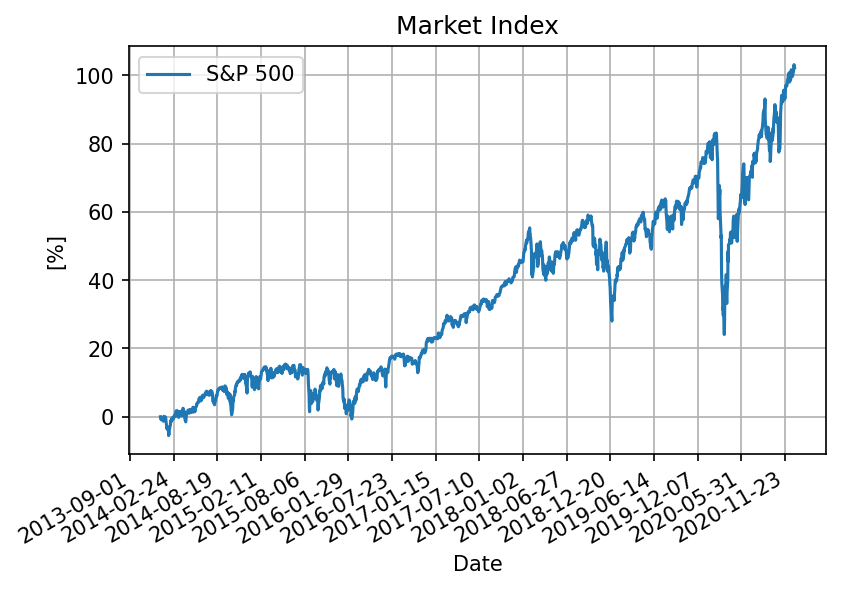

In [12]:
%matplotlib inline
plot_index(market)

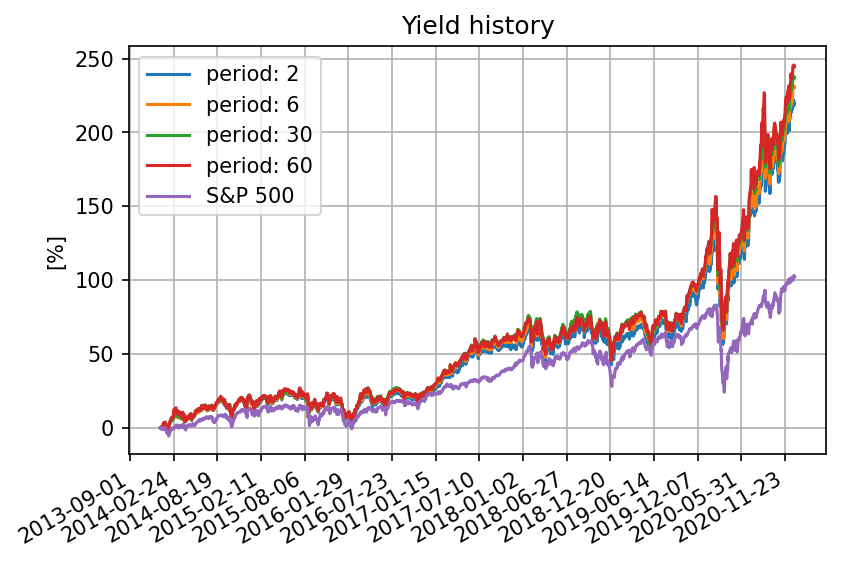

In [13]:
yields(traders_list, periods, 'period', market)

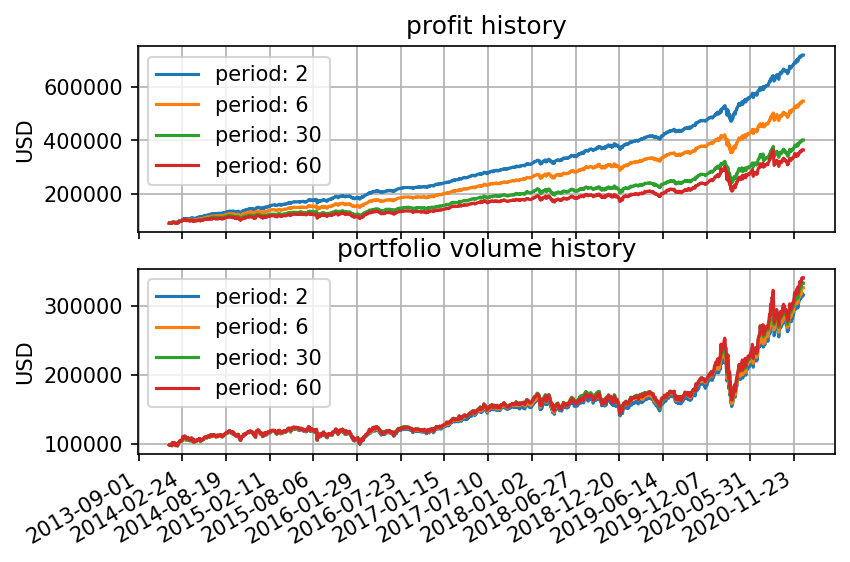

In [14]:
profit_and_portfolio_value(traders_list, periods, 'period')

In [15]:
def yields_usd(traders: list, parameter: list, parameter_name: str, market: Market):
    interval = np.int(len(traders[0].date_history) / 10)
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, dpi=150)
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    axes.set_title('Yield history')

    for i, trader in enumerate(traders):
        axes.plot(trader.date_history, trader.portfolio_value_history, label=parameter_name + ': ' + str(parameter[i]))

    axes.plot(market.index_data.index.to_numpy(), (market.index_return_percent / 100 + 1) * liquid, label='S&P 500')
    axes.set_ylabel('USD')
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    axes.legend()
    axes.grid()
    plt.show()


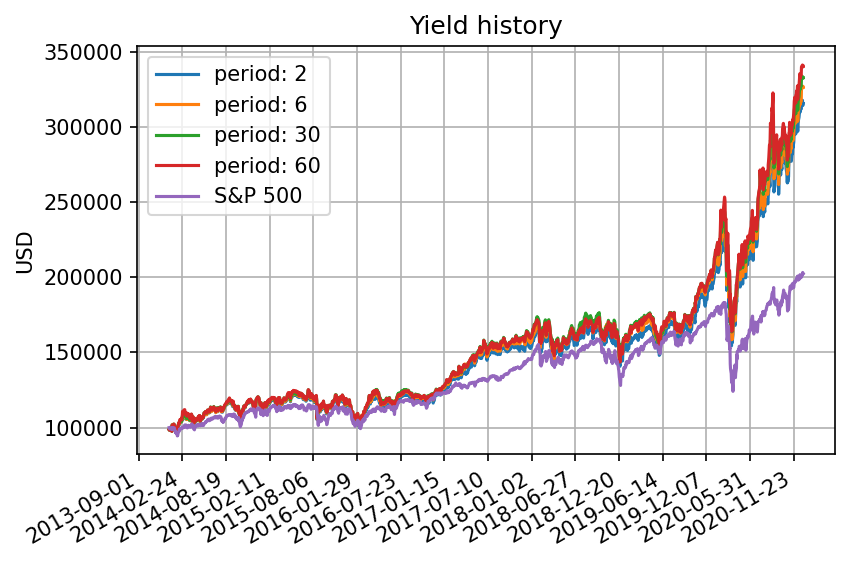

In [16]:
yields_usd(traders_list, periods, 'period', market)